# R Package Dependencies

In [160]:
import pandas
import networkx 

from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf')

data = pandas.DataFrame.from_csv('../data/github-cran-150601.csv')
data['Date'] = pandas.to_datetime(data['Date'])
data = data.sort('Date')

In [161]:
R_packages = ('R MASS Matrix base boot class cluster codetools compiler datasets foreign grDevices ' +
        'graphics grid lattice methods mgcv nlme nnet parallel rpart ' +
        'spatial splines stats stats4 survival tcltk tools translations utils').split(' ')

In [162]:
def data_for_date(data, date):
    return data.query('InCRAN == 1 and Date <= "{date}"'.format(date=date)).drop_duplicates(('Package'), take_last=True).fillna('').set_index('Package', inplace=False)

In [163]:
def graph_for_data(data, ignore_R = True):
    G = networkx.DiGraph()
    G.add_nodes_from(list(data.index))
    for index, row in data.iterrows():
        deps = row['Dependencies'].split(' ')
        for dep in deps: 
            if dep in data.index:
                G.add_edge(index, dep)
    if ignore_R:
        G.remove_nodes_from(R_packages)
    return G

In [164]:
def nodes_properties(G):
    isolated = networkx.isolates(G)

    for node in networkx.topological_sort(G, reverse=True):
        min_strata = len(G.node) + 1
        max_strata = 0
        for successor in G.successors(node):
            if G.node[successor]['max_strata'] > max_strata:
                max_strata = G.node[successor]['max_strata']
            if G.node[successor]['min_strata'] < min_strata:
                min_strata = G.node[successor]['min_strata']
        if min_strata == len(G.node) + 1:
            min_strata = 0
        G.node[node]['min_strata'] = min_strata + 1
        G.node[node]['max_strata'] = max_strata + 1

    packages = pandas.DataFrame.from_dict({n: {'ancestors': len(networkx.ancestors(G, n)),
                                    'descendants': len(networkx.descendants(G, n)),
                                    'out': G.out_degree(n), 
                                    'in': G.in_degree(n),
                                    'isolated': n in isolated,
                                    'min_strata': G.node[n]['min_strata'],
                                    'max_strata': G.node[n]['max_strata']} for n in G.nodes_iter()}, orient='index')
    return packages

In [165]:
dates = pandas.date_range(start='2010-01', end='2015-01', freq='3M')

In [166]:
from collections import OrderedDict

summary = OrderedDict()
graphs = OrderedDict()
props = OrderedDict()

for date in dates:     
    G = graph_for_data(data_for_date(data, date))
    p = nodes_properties(G)
    
    d = OrderedDict()
    d['nodes'] = len(G)

    nonisolated = p.query('isolated == False')
    d['nonisolated'] = len(nonisolated)
    
    d['max ancestors'] = nonisolated['ancestors'].max()
    d['max descendants'] = nonisolated['descendants'].max()
    
    #d['min_strata mean'] = nonisolated['min_strata'].mean()
    #d['max_strata mean'] = nonisolated['max_strata'].mean()
    
    d['min_strata <= 1'] = len(nonisolated.query('min_strata <= 1'))
    d['max_strata <= 1'] = len(nonisolated.query('max_strata <= 1'))
                                                 
    d['min_strata >= 3'] = len(nonisolated.query('min_strata >= 3'))
    d['max_strata >= 3'] = len(nonisolated.query('max_strata >= 3'))
    
    summary[date] = d
    graphs[date] = G
    props[date] = p

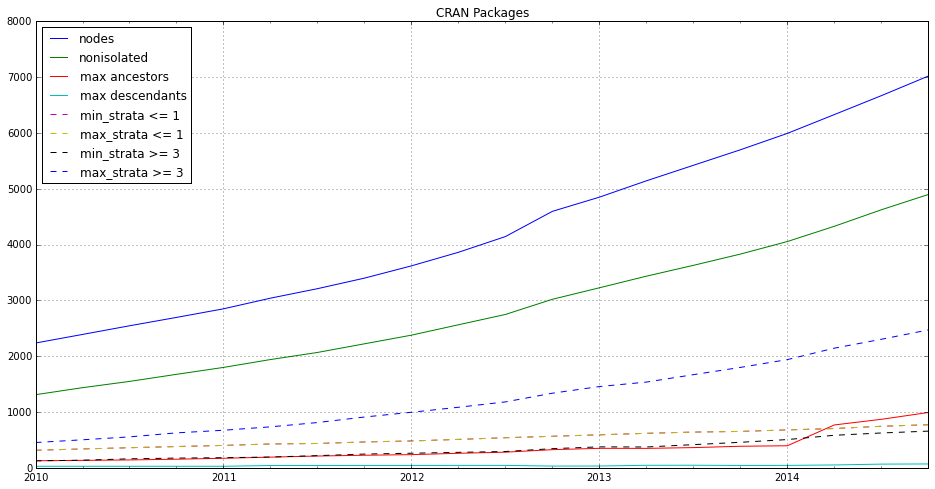

In [167]:
df = pandas.DataFrame.from_dict(summary, orient='index')
df.index = pandas.to_datetime(df.index)

ax = df.plot(style=[None, None, None, None, '--', '--', '--', '--'], title='CRAN Packages')
ax.figure.set_size_inches(16, 8)

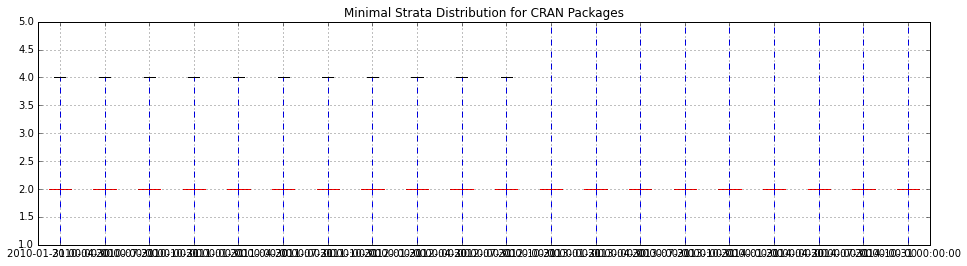

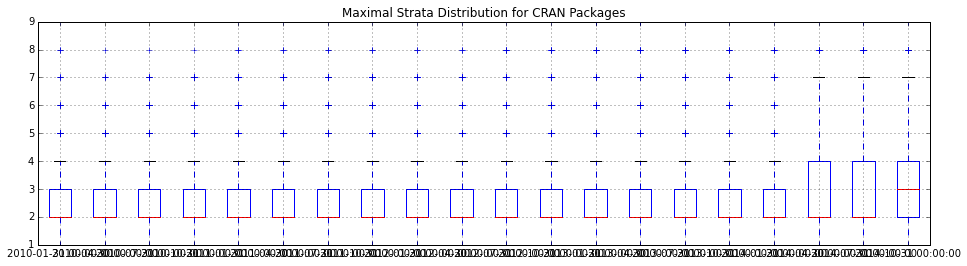

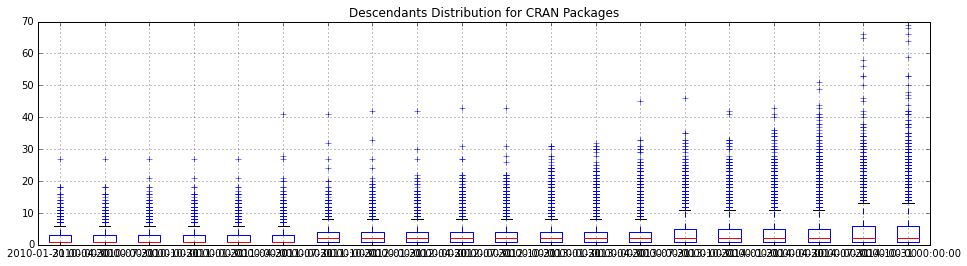

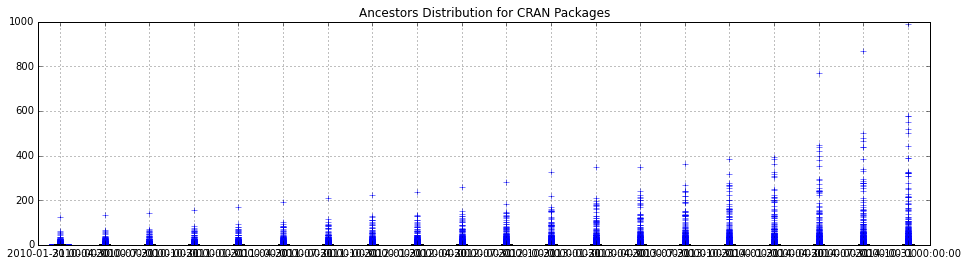

In [168]:
df = pandas.DataFrame.from_dict({date: p.query('isolated == False')['min_strata'] for date, p in props.iteritems()})

ax = df.plot(title='Minimal Strata Distribution for CRAN Packages', kind='box')
ax.figure.set_size_inches(16, 4)

df = pandas.DataFrame.from_dict({date: p.query('isolated == False')['max_strata'] for date, p in props.iteritems()})

ax = df.plot(title='Maximal Strata Distribution for CRAN Packages', kind='box')
ax.figure.set_size_inches(16, 4)

df = pandas.DataFrame.from_dict({date: p.query('isolated == False')['descendants'] for date, p in props.iteritems()})

ax = df.plot(title='Descendants Distribution for CRAN Packages', kind='box')
ax.figure.set_size_inches(16, 4)

df = pandas.DataFrame.from_dict({date: p.query('isolated == False')['ancestors'] for date, p in props.iteritems()})

ax = df.plot(title='Ancestors Distribution for CRAN Packages', kind='box')
ax.figure.set_size_inches(16, 4)



In [169]:
df.sort('2014-07-31 00:00:00', ascending=False, inplace=False)

,2010-01-31 00:00:00,2010-04-30 00:00:00,2010-07-31 00:00:00,2010-10-31 00:00:00,2011-01-31 00:00:00,2011-04-30 00:00:00,2011-07-31 00:00:00,2011-10-31 00:00:00,2012-01-31 00:00:00,2012-04-30 00:00:00,2012-07-31 00:00:00,2012-10-31 00:00:00,2013-01-31 00:00:00,2013-04-30 00:00:00,2013-07-31 00:00:00,2013-10-31 00:00:00,2014-01-31 00:00:00,2014-04-30 00:00:00,2014-07-31 00:00:00,2014-10-31 00:00:00
Rcpp,3,11,15,19,28,30,42,56,80,89,100,126,148,169,189,266,305,768,869,991
plyr,28,37,47,62,68,78,89,111,131,153,183,220,210,240,268,317,360,446,501,575
RColorBrewer,22,32,36,46,53,63,75,96,111,118,134,154,176,202,217,253,383,437,478,575
stringr,0,0,1,10,11,15,20,30,34,104,125,150,183,211,240,275,319,399,464,549
mvtnorm,126,133,141,154,171,191,211,225,236,260,280,325,349,348,362,386,395,420,440,503
digest,28,34,41,52,56,61,77,90,103,111,128,149,178,215,235,269,324,382,437,519
colorspace,27,32,53,58,64,78,94,112,127,129,142,159,194,225,241,264,307,351,383,444
reshape2,NaN,NaN,NaN,0,0,4,6,7,10,71,80,97,120,135,153,184,214,295,338,391
bitops,27,28,30,38,45,56,63,77,90,107,119,153,178,182,200,222,246,292,332,328
zoo,56,60,68,85,94,102,115,126,134,140,149,170,187,200,217,242,251,272,297,388


## Strata for Newly Added R Packages

In [180]:
old_packages = props[props.keys()[0]]

new_data_index = []
new_data = []

for date, ddata in props.iteritems():
    for package, metadata in ddata.iterrows():
        if package not in old_packages.index:
            new_data_index.append(package)
            metadata['snapshot_date'] = date
            new_data.append(metadata)

In [181]:
df = pandas.DataFrame(new_data, index=new_data_index)
df['snapshot_date'] = pandas.to_datetime(df['snapshot_date'])

In [182]:
github = data.query('InGitHub == 1').drop_duplicates('Package')

In [185]:
ndf = github.set_index('Package')[['InGitHub']].join(df, how='right')
ndf = ndf.fillna({'InGitHub': 0})

In [215]:
groups_GH = ndf.query('InGitHub == 1')[['min_strata', 'max_strata', 'snapshot_date']].groupby(by=['snapshot_date'])
groups_CRAN = ndf.query('InGitHub == 0')[['min_strata', 'max_strata', 'snapshot_date']].groupby(by=['snapshot_date'])

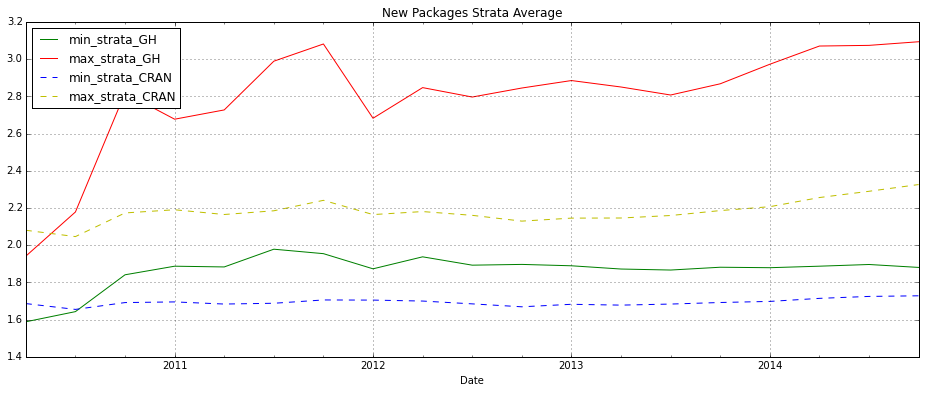

In [223]:
ax = (groups_GH.mean().rename(columns={'min_strata': 'min_strata_GH', 'max_strata': 'max_strata_GH'})
      .plot(title='New Packages Strata Average', style=['g', 'r']))
(groups_CRAN.mean().rename(columns={'min_strata': 'min_strata_CRAN', 'max_strata': 'max_strata_CRAN'})
 .plot(ax=ax, style=['b--', 'y--']))
ax.set_xlabel('Date')

ax.figure.set_size_inches(16, 6)